Credit to:
- [conversion notebook](https://www.kaggle.com/code/kaito510/updated-1xgold-2xsilvers-key-ingredient)
- [simulation notebook](https://www.kaggle.com/code/lennarthaupts/simulate-n-brackets)

# SETUP

## Import

In [15]:
import pandas as pd
import numpy as np

import plotly.express as px
import itertools
import os

import math
import statistics
import copy

## Filepaths

In [16]:
inp_path = './march-machine-learning-mania-2024'
ml_mania_path = './march-machine-learning-mania-2024'

# Load Data

In [17]:
## tourney results
df_labels_men = pd.read_csv(
    os.path.join(
        inp_path,
        'MNCAATourneyDetailedResults.csv')
    )
df_labels_women = pd.read_csv(
    os.path.join(
        inp_path,
        'WNCAATourneyDetailedResults.csv')
    )

## sort labels
df_labels_men = df_labels_men.sort_values(
    by=['Season', 'DayNum']).reset_index(drop=True)
df_labels_women = df_labels_women.sort_values(
    by=['Season', 'DayNum']).reset_index(drop=True)

## team spellings
df_spell_men = pd.read_csv(
    os.path.join(
        inp_path,
        'MTeamSpellings.csv'),
    encoding='cp1252')
df_spell_women = pd.read_csv(
    os.path.join(
        inp_path,
        'WTeamSpellings.csv'),
    encoding='cp1252')

## Mens

In [18]:
## 2024

df_men_2024 = pd.read_excel(
    os.path.join(
        ml_mania_path,
        'March_Madness_2024_Mens.xlsx'
    ),
    index_col = 'team_name'
)

df_men_2024.index.rename(
    'player',
    inplace=True
)

## Womens

In [19]:
## 2024

df_women_2024 = pd.read_excel(
    os.path.join(
        ml_mania_path,
        'March_Madness_2024_Womens.xlsx'
    ),
    index_col = 'team_name'
)

df_women_2024.index.rename(
    'player',
    inplace=True
)

# GOTO CONVERSION

In [20]:
## source: https://github.com/gotoConversion/goto_conversion/

def goto_conversion(
    listOfOdds, 
    total = 1, 
    eps = 1e-6, 
    isAmericanOdds = False):

    ## convert American Odds to Decimal Odds
    if isAmericanOdds:
        for i in range(len(listOfOdds)):
            currOdds = listOfOdds[i]
            isNegativeAmericanOdds = currOdds < 0
            if isNegativeAmericanOdds:
                currDecimalOdds = 1 + (100/(currOdds*-1))
            else: ## non-neg American odds
                currDecimalOdds = 1 + (currOdds/100)
            listOfOdds[i] = currDecimalOdds

    if len(listOfOdds) < 2:
        raise ValueError('len(listOfOdds) must be >= 2')
    if any(x < 1 for x in listOfOdds):
        raise ValueError('All odds must be >= 1, set isAmericanOdds parameter to True if using American Odds')

    listOfProbabilities = [1/x for x in listOfOdds] #initialize probabilities using inverse odds
    listOfSe = [pow((x-x**2)/x,0.5) for x in listOfProbabilities] #compute the standard error (SE) for each probability
    step = (sum(listOfProbabilities) - total)/sum(listOfSe) #compute how many steps of SE the probabilities should step back by
    outputListOfProbabilities = [min(max(x - (y*step),eps),1) for x,y in zip(listOfProbabilities, listOfSe)]
    return outputListOfProbabilities

In [21]:
def set_probabilities_to_sumAtleast1(
    listOfProbabilities, 
    preprocessThreshold = 0.99, 
    total = 1):
    
    multiplier = preprocessThreshold/max(listOfProbabilities)
    listOfProbabilities = [x*multiplier for x in listOfProbabilities]
    
    return listOfProbabilities


def preprocessed_goto_conversion(listOfOdds, total = 1):
    
    listOfProbabilities = [1/x for x in listOfOdds]
    isProbSumBelowTotal = sum(listOfProbabilities) < total
    
    if isProbSumBelowTotal:
        listOfProbabilities = set_probabilities_to_sumAtleast1(listOfProbabilities)
        
        ## unfair odds of losing
        reversedListOfOdds = [1/(1-x) for x in listOfProbabilities] 
        
        ## convert the unfair odds of losing to fair probabilities of losing
        reversedListOfProbabilities = goto_conversion(reversedListOfOdds)
        
        ## convert fair probabilities of losing to fair probabilities of winning
        outputListOfProbabilities = [1-x for x in reversedListOfProbabilities] 
    else:
        outputListOfProbabilities = goto_conversion(listOfOdds)
    return outputListOfProbabilities

## Modified Matchup Generation

In [22]:
## load bracket data
bracket_men_2024 = pd.read_csv('./march-machine-learning-mania-2024/MNCAATourneySlots.csv')
bracket_women_2024 = pd.read_csv('./march-machine-learning-mania-2024/WNCAATourneySlots.csv')

bracket_men_2024 = bracket_men_2024.loc[bracket_men_2024['Season']==2024]
bracket_women_2024 = bracket_women_2024.loc[bracket_women_2024['Season']==2024]

In [23]:
## seeding: updated after First Four
seeds_2024 = pd.read_csv('./march-machine-learning-mania-2024/2024_tourney_seeds.csv')
seeds_men_2024 = seeds_2024.loc[seeds_2024['Tournament']=='M']
seeds_women_2024 = seeds_2024.loc[seeds_2024['Tournament']=='W']

In [24]:
transition_men = {}
transition_women = {}

CHAMP = 'R6CH' ## label denotes march madness champ

## create transition matrix for how each seed advances through the bracket
for i, row in bracket_men_2024.iterrows():
    transition_men[row['StrongSeed']] = row['Slot']
    transition_men[row['WeakSeed']] = row['Slot']

for i, row in bracket_women_2024.iterrows():
    transition_women[row['StrongSeed']] = row['Slot']
    transition_women[row['WeakSeed']] = row['Slot']
    
print(transition_men)

{'W01': 'R1W1', 'W16': 'R1W1', 'W02': 'R1W2', 'W15': 'R1W2', 'W03': 'R1W3', 'W14': 'R1W3', 'W04': 'R1W4', 'W13': 'R1W4', 'W05': 'R1W5', 'W12': 'R1W5', 'W06': 'R1W6', 'W11': 'R1W6', 'W07': 'R1W7', 'W10': 'R1W7', 'W08': 'R1W8', 'W09': 'R1W8', 'X01': 'R1X1', 'X16': 'R1X1', 'X02': 'R1X2', 'X15': 'R1X2', 'X03': 'R1X3', 'X14': 'R1X3', 'X04': 'R1X4', 'X13': 'R1X4', 'X05': 'R1X5', 'X12': 'R1X5', 'X06': 'R1X6', 'X11': 'R1X6', 'X07': 'R1X7', 'X10': 'R1X7', 'X08': 'R1X8', 'X09': 'R1X8', 'Y01': 'R1Y1', 'Y16': 'R1Y1', 'Y02': 'R1Y2', 'Y15': 'R1Y2', 'Y03': 'R1Y3', 'Y14': 'R1Y3', 'Y04': 'R1Y4', 'Y13': 'R1Y4', 'Y05': 'R1Y5', 'Y12': 'R1Y5', 'Y06': 'R1Y6', 'Y11': 'R1Y6', 'Y07': 'R1Y7', 'Y10': 'R1Y7', 'Y08': 'R1Y8', 'Y09': 'R1Y8', 'Z01': 'R1Z1', 'Z16': 'R1Z1', 'Z02': 'R1Z2', 'Z15': 'R1Z2', 'Z03': 'R1Z3', 'Z14': 'R1Z3', 'Z04': 'R1Z4', 'Z13': 'R1Z4', 'Z05': 'R1Z5', 'Z12': 'R1Z5', 'Z06': 'R1Z6', 'Z11': 'R1Z6', 'Z07': 'R1Z7', 'Z10': 'R1Z7', 'Z08': 'R1Z8', 'Z09': 'R1Z8', 'R1W1': 'R2W1', 'R1W8': 'R2W1', 'R1W2':

In [25]:
## map TeamID --> predictions

## create dicts for mapping names
dct_mens_names = {row['TeamNameSpelling']: row['TeamID'] for (i, row) in df_spell_men.iterrows()}
dct_womens_names = {row['TeamNameSpelling']: row['TeamID'] for (i, row) in df_spell_women.iterrows()}
dct_womens_names['tamu-corpus christi'] = 3394 ## the one that got away

## map map map
df_men_2024['TeamID'] = df_men_2024.index.str.lower().map(dct_mens_names)
df_women_2024['TeamID'] = df_women_2024.index.str.lower().map(dct_womens_names)

## check any we missed
display(df_men_2024[df_men_2024['TeamID'].isnull()])
display(df_women_2024[df_women_2024['TeamID'].isnull()])

## removes edge case for rd1
df_men_2024['rd0_win'] = 1
df_women_2024['rd0_win'] = 1

,team_seed,team_region,rd1_win,rd2_win,rd3_win,rd4_win,rd5_win,rd6_win,rd7_win,win_odds,TeamID
player,,,,,,,,,,,


,team_seed,team_region,rd1_win,rd2_win,rd3_win,rd4_win,rd5_win,rd6_win,rd7_win,win_odds,TeamID
player,,,,,,,,,,,


In [26]:
## create every possible matchup combo between seeds
matchups_men = pd.DataFrame()
matchups_men[['T1','T2']] = list(itertools.product(seeds_men_2024['TeamID'], seeds_men_2024['TeamID']))

matchups_women = pd.DataFrame()
matchups_women[['T1','T2']] = list(itertools.product(seeds_women_2024['TeamID'], seeds_women_2024['TeamID']))

matchups_men = matchups_men.merge(
    seeds_men_2024[['Seed','TeamID']],
    left_on='T1', right_on='TeamID',
    how='left'
).rename(
    columns={'Seed':'Seed1'}
).merge(
    seeds_men_2024[['Seed','TeamID']],
    left_on='T2', right_on='TeamID',
    how='left'
).rename(
    columns={'Seed':'Seed2'}
).drop(
    columns = list(matchups_men.columns[matchups_men.columns.str.contains('TeamID')])
)

matchups_women = matchups_women.merge(
    seeds_women_2024[['Seed','TeamID']],
    left_on='T1', right_on='TeamID',
    how='left'
).rename(
    columns={'Seed':'Seed1'}
).merge(
    seeds_women_2024[['Seed','TeamID']],
    left_on='T2', right_on='TeamID',
    how='left'
).rename(
    columns={'Seed':'Seed2'}
).drop(
    columns = list(matchups_women.columns[matchups_women.columns.str.contains('TeamID')])
)

print('CHECK FOR NULL VALUES:')
print(f"{'='*5}MENS{'='*5}")
display(matchups_men.isnull().sum())
print(f"{'='*5}WOMENS{'='*5}")
display(matchups_women.isnull().sum())

CHECK FOR NULL VALUES:
=====MENS=====


T1          0
T2          0
Seed1       0
TeamID_x    0
Seed2       0
TeamID_y    0
dtype: int64

=====WOMENS=====


T1          0
T2          0
Seed1       0
TeamID_x    0
Seed2       0
TeamID_y    0
dtype: int64

In [27]:
transition_men

{'W01': 'R1W1',
 'W16': 'R1W1',
 'W02': 'R1W2',
 'W15': 'R1W2',
 'W03': 'R1W3',
 'W14': 'R1W3',
 'W04': 'R1W4',
 'W13': 'R1W4',
 'W05': 'R1W5',
 'W12': 'R1W5',
 'W06': 'R1W6',
 'W11': 'R1W6',
 'W07': 'R1W7',
 'W10': 'R1W7',
 'W08': 'R1W8',
 'W09': 'R1W8',
 'X01': 'R1X1',
 'X16': 'R1X1',
 'X02': 'R1X2',
 'X15': 'R1X2',
 'X03': 'R1X3',
 'X14': 'R1X3',
 'X04': 'R1X4',
 'X13': 'R1X4',
 'X05': 'R1X5',
 'X12': 'R1X5',
 'X06': 'R1X6',
 'X11': 'R1X6',
 'X07': 'R1X7',
 'X10': 'R1X7',
 'X08': 'R1X8',
 'X09': 'R1X8',
 'Y01': 'R1Y1',
 'Y16': 'R1Y1',
 'Y02': 'R1Y2',
 'Y15': 'R1Y2',
 'Y03': 'R1Y3',
 'Y14': 'R1Y3',
 'Y04': 'R1Y4',
 'Y13': 'R1Y4',
 'Y05': 'R1Y5',
 'Y12': 'R1Y5',
 'Y06': 'R1Y6',
 'Y11': 'R1Y6',
 'Y07': 'R1Y7',
 'Y10': 'R1Y7',
 'Y08': 'R1Y8',
 'Y09': 'R1Y8',
 'Z01': 'R1Z1',
 'Z16': 'R1Z1',
 'Z02': 'R1Z2',
 'Z15': 'R1Z2',
 'Z03': 'R1Z3',
 'Z14': 'R1Z3',
 'Z04': 'R1Z4',
 'Z13': 'R1Z4',
 'Z05': 'R1Z5',
 'Z12': 'R1Z5',
 'Z06': 'R1Z6',
 'Z11': 'R1Z6',
 'Z07': 'R1Z7',
 'Z10': 'R1Z7',
 'Z08': 

In [28]:
matchups_men.head()

,T1,T2,Seed1,TeamID_x,Seed2,TeamID_y
0,1163,1163,W01,1163,W01,1163
1,1163,1235,W01,1163,W02,1235
2,1163,1228,W01,1163,W03,1228
3,1163,1120,W01,1163,W04,1120
4,1163,1361,W01,1163,W05,1361


In [29]:
df_men_2024.head()

,team_seed,team_region,rd1_win,rd2_win,rd3_win,rd4_win,rd5_win,rd6_win,rd7_win,win_odds,TeamID,rd0_win
player,,,,,,,,,,,,
Connecticut,1,East,1.0,0.995022,0.894013,0.726081,0.566816,3.612327e-01,2.254101e-01,3.436358e+00,1163,1
Stetson,16,East,1.0,0.004978,0.000662,0.000057,0.000004,2.754882e-07,1.889276e-08,5.293033e+07,1391,1
Florida Atlantic,8,East,1.0,0.654673,0.082247,0.035146,0.013567,4.694501e-03,1.589201e-03,6.282471e+02,1194,1
Northwestern,9,East,1.0,0.345327,0.023079,0.007192,0.002000,5.327040e-04,1.405062e-04,7.116121e+03,1321,1
San Diego State,5,East,1.0,0.780579,0.315185,0.044958,0.015596,6.736916e-03,2.847461e-03,3.501901e+02,1361,1


In [13]:
## MEN

correctProbs_list = []

for i, row in matchups_men.iterrows():
    ## for each pair of teams, what's the first rd they meet?
    sd1 = row['Seed1']
    sd2 = row['Seed2']
    
    while sd1 != sd2:
        sd1 = transition_men[sd1]
        sd2 = transition_men[sd2]
    
    rd = int(sd1[1])
#     print(f"{row['Seed1']}, {row['Seed2']} --> {rd}")
    
    ## conditional prob adjustment
    wteam_winGivenReach_prob = df_men_2024.loc[
        df_men_2024['TeamID']==row['T1'],f'rd{rd+1}_win'] / df_men_2024.loc[
        df_men_2024['TeamID']==row['T1'],f'rd{rd}_win']
    lteam_winGivenReach_prob = df_men_2024.loc[
        df_men_2024['TeamID']==row['T2'],f'rd{rd+1}_win'] / df_men_2024.loc[
        df_men_2024['TeamID']==row['T2'],f'rd{rd}_win']
    
#     print(wteam_winGivenReach_prob, lteam_winGivenReach_prob)
    
    ## goto conversion step
    convertedProbs = preprocessed_goto_conversion(
        [1/wteam_winGivenReach_prob[0], 
         1/lteam_winGivenReach_prob[0]])
    correctProbs_list.append(convertedProbs) #We use the probability for correct label to calculate score

matchups_men[['Pred','bar_pred']] = correctProbs_list

/var/folders/bg/q5cqnlzn75sfv4yb_k6p9pcm0000gn/T/ipykernel_89110/1906905250.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [1/wteam_winGivenReach_prob[0],
/var/folders/bg/q5cqnlzn75sfv4yb_k6p9pcm0000gn/T/ipykernel_89110/1906905250.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1/lteam_winGivenReach_prob[0]])
/var/folders/bg/q5cqnlzn75sfv4yb_k6p9pcm0000gn/T/ipykernel_89110/585276420.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  step = (sum(listOfProbabilities) - total)/sum(listOfSe) #compute how many steps of SE the probabilities should step back by
/var/folders/bg/q5cqnlzn75sfv4yb_k

In [14]:
## WOMEN

correctProbs_list = []

for i, row in matchups_women.iterrows():
    ## for each pair of teams, what's the first rd they meet?
    sd1 = row['Seed1']
    sd2 = row['Seed2']
    
    while sd1 != sd2:
        sd1 = transition_women[sd1]
        sd2 = transition_women[sd2]
    
    rd = int(sd1[1])
#     print(f"{row['Seed1']}, {row['Seed2']} --> {rd}")
    
    ## conditional prob adjustment
    wteam_winGivenReach_prob = df_women_2024.loc[
        df_women_2024['TeamID']==row['T1'],f'rd{rd+1}_win'] / df_women_2024.loc[
        df_women_2024['TeamID']==row['T1'],f'rd{rd}_win']
    lteam_winGivenReach_prob = df_women_2024.loc[
        df_women_2024['TeamID']==row['T2'],f'rd{rd+1}_win'] / df_women_2024.loc[
        df_women_2024['TeamID']==row['T2'],f'rd{rd}_win']
    
#     print(wteam_winGivenReach_prob, lteam_winGivenReach_prob)

    ## goto conversion step
    convertedProbs = preprocessed_goto_conversion(
        [1/wteam_winGivenReach_prob[0], 
         1/lteam_winGivenReach_prob[0]])
    correctProbs_list.append(convertedProbs) #We use the probability for correct label to calculate score

matchups_women[['Pred','bar_pred']] = correctProbs_list

/var/folders/bg/q5cqnlzn75sfv4yb_k6p9pcm0000gn/T/ipykernel_89110/1589597478.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [1/wteam_winGivenReach_prob[0],
/var/folders/bg/q5cqnlzn75sfv4yb_k6p9pcm0000gn/T/ipykernel_89110/1589597478.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1/lteam_winGivenReach_prob[0]])
/var/folders/bg/q5cqnlzn75sfv4yb_k6p9pcm0000gn/T/ipykernel_89110/585276420.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  step = (sum(listOfProbabilities) - total)/sum(listOfSe) #compute how many steps of SE the probabilities should step back by
/var/folders/bg/q5cqnlzn75sfv4yb_k

In [15]:
## CHECK: any null rows that aren't caused by a team being matched against itself?
display(
    matchups_women.loc[
        (matchups_women[['Pred','bar_pred']].isnull().any(axis=1)) &\
        (matchups_women['T1'] != matchups_women['T2'])]
)

display(
    matchups_men.loc[
        (matchups_men[['Pred','bar_pred']].isnull().any(axis=1)) &\
        (matchups_men['T1'] != matchups_men['T2'])]
)

,T1,T2,Seed1,TeamID_x,Seed2,TeamID_y,Pred,bar_pred


,T1,T2,Seed1,TeamID_x,Seed2,TeamID_y,Pred,bar_pred


In [16]:
## formatting
matchups_men['ID'] = [[2024, str(x), str(y)] for x, y in zip(matchups_men['T1'], matchups_men['T2'])]
matchups_women['ID'] = [[2024, str(x), str(y)] for x, y in zip(matchups_women['T1'], matchups_women['T2'])]

In [17]:
# This is a similarly formatted submission for 2023 and prior competitions. It includes every possible matchup of every team in all of college
# basketball. All of the code below is taken from the link in the readme, it uses this type of submission format to simulate and construct
# a specified number of brackets. It creates a file called submission.csv, formatted correctly for the 2024 competition. See the readme link for
# the required columns. 
matchups_men.head()

,T1,T2,Seed1,TeamID_x,Seed2,TeamID_y,Pred,bar_pred,ID
0,1163,1163,W01,1163,W01,1163,NaN,NaN,"[2024, 1163, 1163]"
1,1163,1235,W01,1163,W02,1235,0.736155,0.263845,"[2024, 1163, 1235]"
2,1163,1228,W01,1163,W03,1228,0.744798,0.255202,"[2024, 1163, 1228]"
3,1163,1120,W01,1163,W04,1120,0.774469,0.225531,"[2024, 1163, 1120]"
4,1163,1361,W01,1163,W05,1361,0.874521,0.125479,"[2024, 1163, 1361]"


# SUBMISSION

In [18]:
import numpy as np 
import pandas as pd 
from tqdm import tqdm

# Load and filter data
round_slots = pd.read_csv('./march-machine-learning-mania-2024/MNCAATourneySlots.csv')
round_slots = round_slots[round_slots['Season'] == 2024]
round_slots = round_slots[round_slots['Slot'].str.contains('R')] # Filter out First Four

seeds = pd.read_csv('./march-machine-learning-mania-2024/2024_tourney_seeds.csv')
seeds_m = seeds[seeds['Tournament'] == 'M']
seeds_w = seeds[seeds['Tournament'] == 'W']

In [19]:
def prepare_data(seeds, preds):
    # Function preparing the data for the simulation
    seed_dict = seeds.set_index('Seed')['TeamID'].to_dict()
    inverted_seed_dict = {value: key for key, value in seed_dict.items()}
    probas_dict = {}
    
    for teams, proba in zip(preds['ID'], preds['Pred']):
        team1, team2 = teams[1], teams[2]

        probas_dict.setdefault(team1, {})[team2] = proba
        probas_dict.setdefault(team2, {})[team1] = 1 - proba

    return seed_dict, inverted_seed_dict, probas_dict


def simulate(round_slots, seeds, inverted_seeds, probas, random_values, sim=True):
    '''
    Simulates each round of the tournament.

    Parameters:
    - round_slots: DataFrame containing information on who is playing in each round.
    - seeds (dict): Dictionary mapping seed values to team IDs.
    - inverted_seeds (dict): Dictionary mapping team IDs to seed values.
    - probas (dict): Dictionary containing matchup probabilities.
    - random_values (array-like): Array with precomputed random-values.
    - sim (boolean): Simulates match if True. Chooses team with higher probability as winner otherwise.

    Returns:
    - list: List with winning team IDs for each match.
    - list: List with corresponding slot names for each match.
    '''
    winners = []
    slots = []

    for slot, strong, weak, random_val in zip(round_slots.Slot, round_slots.StrongSeed, round_slots.WeakSeed, random_values):
        team1, team2 = seeds[strong], seeds[weak]

        # Get the probability of team_1 winning
#         print(team1, team2)
#         print(probas)
        proba = probas[str(team1)][str(team2)]
            
        if sim:
            # Randomly determine the winner based on the probability
            winner = team1 if random_val < proba else team2
        else:
            # Determine the winner based on the higher probability
            winner = [team1, team2][np.argmax([proba, 1-proba])]
            
        # Append the winner and corresponding slot to the lists
        winners.append(winner)
        slots.append(slot)

        seeds[slot] = winner

    # Convert winners to original seeds using the inverted_seeds dictionary
    return [inverted_seeds[w] for w in winners], slots


def run_simulation(brackets=1, seeds=None, preds=None, round_slots=None, sim=True):
    '''
    Runs a simulation of bracket tournaments.

    Parameters:
    - brackets (int): Number of brackets to simulate.
    - seeds (pd.DataFrame): DataFrame containing seed information.
    - preds (pd.DataFrame): DataFrame containing prediction information for each match-up.
    - round_slots (pd.DataFrame): DataFrame containing information about the tournament rounds.
    - sim (boolean): Simulates matches if True. Chooses team with higher probability as winner otherwise.

    Returns:
    - pd.DataFrame: DataFrame with simulation results.
    '''
    # Get relevant data for the simulation
    seed_dict, inverted_seed_dict, probas_dict = prepare_data(seeds, preds)
    # Lists to store simulation results
    results = []
    bracket = []
    slots = []
    
    # Precompute random-values
    random_values = np.random.random(size=(brackets, len(round_slots)))

    # Iterate through the specified number of brackets
    for b in tqdm(range(1, brackets+1)):
        # Run single simulation
        r, s = simulate(round_slots, seed_dict, inverted_seed_dict, probas_dict, random_values[b-1], sim)
        
        # Update results
        results.extend(r)
        bracket.extend([b] * len(r))
        slots.extend(s)

    # Create final DataFrame
    result_df = pd.DataFrame({'Bracket': bracket, 'Slot': slots, 'Team': results})

    return result_df

In [20]:
n_brackets = 100000

## mens
result_m=run_simulation(
    brackets=n_brackets, 
    seeds=seeds_m, 
    preds=matchups_men, 
    round_slots=round_slots, 
    sim=True)
result_m['Tournament'] = 'M'

## womens
result_w=run_simulation(
    brackets=n_brackets, 
    seeds=seeds_w, 
    preds=matchups_women, 
    round_slots=round_slots, 
    sim=True)
result_w['Tournament'] = 'W'

submission = pd.concat([result_m, result_w])
submission.reset_index(inplace=True, drop=True)
submission.index.names = ['RowId']

100%|██████████| 100000/100000 [00:02<00:00, 45467.32it/s]


In [21]:
submission.to_csv('submission.csv')

## Check Brackets: Analysis

In [22]:
anal_m, anal_w = result_m.copy(), result_w.copy()

anal_m['rd'] = anal_m['Slot'].str.slice(start=1, stop=2)
anal_w['rd'] = anal_w['Slot'].str.slice(start=1, stop=2)

In [23]:
teams_per_rd = df_men_2024[
    ['rd2_win', 'rd3_win', 'rd4_win', 'rd5_win', 'rd6_win','rd7_win']].sum().values

In [24]:
## MENS

anal_m = anal_m.merge(
    seeds_m[['Seed','TeamID']],
    left_on='Team', right_on='Seed',
    how='left'
).merge(
    df_men_2024.reset_index()[['player','TeamID']],
    on='TeamID'
)

df_sim_m = anal_m.groupby(
    ['player','rd'])['Seed'].count().to_frame().unstack(
    level=1
)
df_sim_m.columns = df_sim_m.columns.droplevel()

## adjust row counts to likelihood of advancing
df_sim_m = df_sim_m.div(
    df_sim_m.sum(), axis=1
).mul(
    teams_per_rd, axis=1
)

In [25]:
df_ref_m = df_men_2024[
    ['rd2_win', 'rd3_win', 'rd4_win', 'rd5_win', 'rd6_win','rd7_win']]
df_ref_m.columns = list(np.arange(1,7))

## find diff: pre vs. post-goto conversion
df_diff_m = df_ref_m.loc[df_sim_m.index].sort_index().values - df_sim_m.sort_index().values

df_diff_m = pd.DataFrame(
    df_diff_m,
    index = df_sim_m.index,
    columns = df_sim_m.columns
)

getting crushed by the goto conversion:
* Boise State (lost their play-in; won't appear in private LB)
* Colorado State (won the play-in)
* Florida
* Marquette
* Texas

In [26]:
class Percent(float):
    def __str__(self):
        return '{:.1%}'.format(self)

def get_heatMap(output_df, rounds_list, title):
    output_df = output_df.sort_values(by=output_df.columns.tolist()[-1], ascending=False)
    players_list = output_df.index.tolist()
    probabilities_npMatrix = [[Percent(e) for e in l] for l in output_df.values.tolist()]
    probabilitiesText_npMatrix = np.array(probabilities_npMatrix, dtype='str_')

    fig = px.imshow(probabilities_npMatrix, x=rounds_list, y=players_list, color_continuous_scale='Greens', aspect="auto", width=800, height=1600)
    fig.update_traces(text=probabilitiesText_npMatrix , texttemplate="%{text}")
    fig.update_xaxes(side="top")
    fig.update(layout_coloraxis_showscale=False)
    fig.update_layout(title=title)
    fig.show()
    


<Axes: xlabel='rd', ylabel='player'>

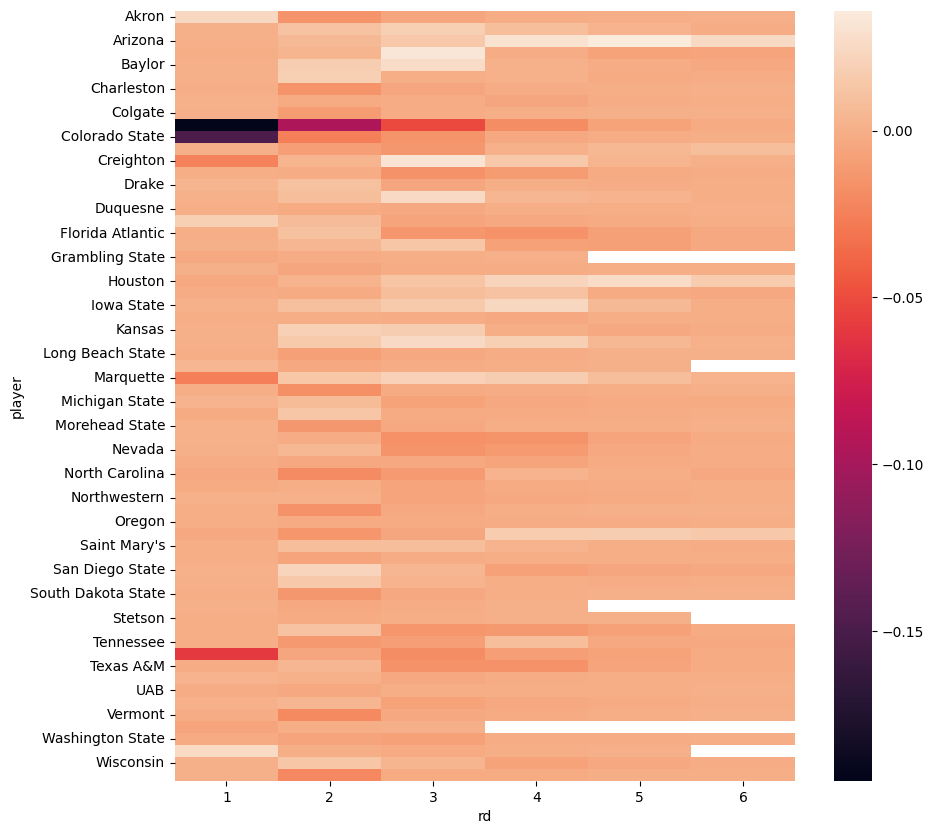

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

## visualize differences of prob for each team
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_diff_m, ax=ax)

In [28]:
## visualize advancement
get_heatMap(
    df_sim_m, 
    rounds_list = ['Reach R2', 'Reach S16', 'Reach E8', 'Reach F4', 'Reach CG', 'Champion'],
    title = 'CHECK: Mens March Madness 2024')

In [29]:
## WOMENS

anal_w = anal_w.merge(
    seeds_w[['Seed','TeamID']],
    left_on='Team', right_on='Seed',
    how='left'
).merge(
    df_women_2024.reset_index()[['player','TeamID']],
    on='TeamID'
)

df_sim_w = anal_w.groupby(
    ['player','rd'])['Seed'].count().to_frame().unstack(
    level=1
)
df_sim_w.columns = df_sim_w.columns.droplevel()

## adjust row counts to likelihood of advancing
df_sim_w = df_sim_w.div(
    df_sim_w.sum(), axis=1
).mul(
    teams_per_rd, axis=1
)

In [30]:

df_ref_w = df_women_2024[
    ['rd2_win', 'rd3_win', 'rd4_win', 'rd5_win', 'rd6_win','rd7_win']]
df_ref_w.columns = list(np.arange(1,7))

df_diff_w = df_ref_w.loc[df_sim_w.index].sort_index().values - df_sim_w.sort_index().values

df_diff_w = pd.DataFrame(
    df_diff_w,
    index = df_sim_w.index,
    columns = df_sim_w.columns
)

- Arizona
- Baylor
- Columbia

<Axes: xlabel='rd', ylabel='player'>

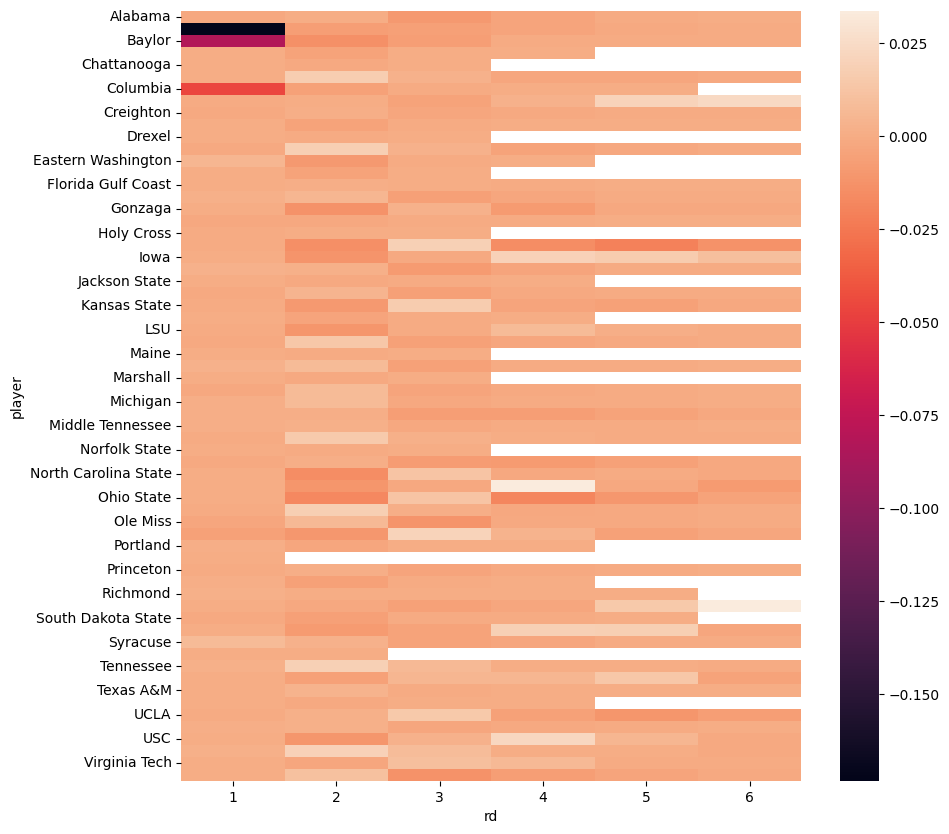

In [31]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_diff_w, ax=ax)

In [32]:
get_heatMap(
    df_sim_w, 
    rounds_list = ['Reach R2', 'Reach S16', 'Reach E8', 'Reach F4', 'Reach CG', 'Champion'],
    title = 'CHECK: Womens March Madness 2024')